***Mão na massa 2!***

* Treine o modelo mais algumas vezes, variando os valores dos hiperparâmetros apresentados. Analise os efeitos nos resultados. Leia a [referência do modelo](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) e faça o mesmo com outros hiperparâmetros que não discutimos. Tente superar o desempenho acima :)

In [24]:
# importação de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from os import system

%matplotlib inline

In [25]:
%%javascript
(function(){
    var startTime;
    $([Jupyter.events]).on('execute.CodeCell', function(event, target)
    {
        startTime = performance.now();
    });
    $([Jupyter.events]).on('finished_iopub.Kernel', function(event, target)
    {
        var endTime = performance.now();

        if(endTime - startTime > 10 * 1000)
        {
            var audio = new Audio('http://www.soundjay.com/button/beep-07.wav');
            audio.play();    
        }
    });
})()

<IPython.core.display.Javascript object>

A função a cima tem o objetivo de somente emitir um aviso sonoro quando a célula terminou de ser executada (útil para execuções que levam muito tempo)

## Importação dos Dados

In [26]:
df_raw = pd.read_csv(f'../input/blue-book-for-bulldozer/Train/Train.csv', 
                     low_memory=False, 
                     parse_dates=["saledate"])

df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

## Data Cleaning

0 - SalesID: Não é uma variável que deve afetar o preço pois é somente um ID da venda. Pode haver alguma relação por causa que é um indicativo de tempo, porém já existe a coluna saledate, portando essa coluna é no mínimo redundante. Será setada para index e não será utilizada no treinamento do modelo.

1 - SalePrice: preço de venda coluna Target. Será adotado o logaritimo.

2 - MachineID: Representa o ID do trator. Tratores diferentes possuem preços diferentes. Para modelos com muitas vendas essa coluna será útil. Porém para modelos que são novos, não tem venda é pouco representativa.

3 - ModelID: Assim como MachineID essa variável é categórica por representar o modelo do trator.

4 - datasource: Essa variável representa da onde foi tirado o dado logo é uma variável categórica também mas ela é redundante com a auctioneerID que representa o leilão de venda logo será retirada.

5 - auctioneerID: ID do leiloeiro é uma variável categórica que representa o leilão de venda (o local pode influenciar bastante no preço de venda). Os locais que questão sem o código serão substítuidos pela moda.

6 - YearMade: Representa o ano de fabricação do trator essa variável e que realmente pode afetar o preço. Porém ela apresenta um erro que há muitos tratores que foram fabricados no ano 1000 que é claramente um erro que será corrigido alterando a data de fabricação para 5 anos antes da data de venda que é a maioria dos casos, também há casos em que a data de fabricação é anterior a data de venda que são raros e serão removidas essas linhas. Será adicionada a coluna 'YearsOld' que representará a diferença entre data de fabricação de venda.

7 - MachineHoursCurrentMeter: Horas de uso do trator antes da venda, valores null e zeros significam que o número de horas não foi informado e serão substituídos pela mediana.

8 - UsageBand: Representa uma comparação entre o número de horas que a máquina foi utilizada e a vida útil.

9 - saledate: Data de venda do trator. Será utilizada para determinar quantos anos de uso tem o equipamento e convertido somente para o ano.

10 e 11 - fiModelDesc e fiBaseModel: Representam características do trator. Existem muitas categorias diferentes, para tratores que só tem um com determinado modelo ou característica será definido como uma categoria única.

12 ,13 e 14 - fiSecondaryDesc, fiModelSeries e fiModelDescriptor: Também apresentam descrições dos tratores mas apresentam muitos dados faltantes.

15 - ProductSize: Apresenta o tamanho do equipamento, com categorias large, medium, small, mini, compact e large/medium será convertido para numeros inteiros sendo 5 o maior 0 o menor e -1 faltantes.

16 - fiProductClassDesc: Apresenta um texto descrevendo o equipamento. É um agregado de outras colunas e será removida.

17 - state: Estado que o equipamento foi vendido. O preço pode variar de acordo com o estado logo será mantido.

18 e 19 - ProductGroup e ProductGroupDesc: Representa o tipo de equipamento. Como ProductGroup é o código e será removida a descrição.

20 - Drive_System: O tipo de tração do equipamento.

21 - Enclosure: Representa características da cabine.

22 - Forks: Representa a configuração utilizada para elevação.

23 - Pad_Type: Tipo de esteira que o equipamento usa.

24 - Ride_Control: adicional do equipamento.

25 - Stick: Tipo de controle.

26 - Transmission: Tipo de sistema de marchas. Há duas categorias que estão somente escritas de forma diferente 'Autoshift' e 'AuthoShift', a colunas vai ser convertida para lower case assim unindo esses dois.

27 - Turbocharged: Se o motor possui turbo. Será convertida para uma coluna boleana.

28 - Blade_Extension: Se lâmina é estendida ou padrão.

29 - Blade_Width: Largura da lâmina. Será convertido em int.

30 - Enclosure_Type: Tipo da cabine.

31 - Engine_Horsepower: Classificação de potência do motor. Essa coluna tem dois valores 'No' e 'Variable' contém 90% dos valores faltantes e os que não faltam são 'No' logo será retirado. 

32 - Hydraulics: Tipo de sistema hidráulico.

33 - Pushblock: Opcional. Será convertido em uma coluna boleana.

34 - Ripper: Opcional para cultivar o solo.

35 - Scarifier: Opcional para cultivar o solo. Será convertida boleana.

36 - Tip_control: Tipo de controle da lâmina. Possui as categorias 'tip_control_sideshift_and_tip' e 'tip_control_tip'

37 - Tire_Size: Tamanho do pneu. Será convertido para float.

38 - Coupler: ???. Possui duas categorias 'manual' e hydraulic'

39 - Coupler_System: ???. Será convertida para uma coluna boleana.

40 - Grouser_Tracks: Descreve interface de contato com o solo. Será convertida para uma coluna boleana.

41 - Hydraulics_Flow: Descreve o fluxo de hidraúlico. Possui duas categorias 'standard' e 'high flow'.

42 - Track_Type: Tipo de esteira. Possui duas categorias 'steel' e 'rubber'.

43 - Undercarriage_Pad_Width: Laragura do passo da esteira. Será convertido para float.

44 - Stick_Length: Comprimento do acessório de escavação.

45 - Thumb: Acessorio utlizado para agarrar. Possui duas categorias 'manual' e 'hydraulic'.

46 - Pattern_Changer: Possiblidade de ajuste do controle. Possui duas categorias 'Yes' e 'No'

47 - Grouser_Type: Tipo de esteira que a máquina utiliza. Possui três categorias 'double', 'triple' e 'sigle'.

48 - Backhoe_Mounting: Interface opcional para retroescavadeira. Só há 20 máquinas com essa coluna igual a 'Yes' logo será descartada.

49 - Blade_Type: Descreve o tipo de lâmina.

50 - Travel_Controls: Configuração do controle.

51 - Differential_Type: ???. Possui as categorias 'standard', 'limited_slip', 'no spin' e 'Locking'.

52 - Steering_Controls: Descreve a configuração de controle. Possui as categorias 'command_control', 'four_wheel_standard'

### Removing Columns

In [28]:
drop_columns = ['datasource', 'Backhoe_Mounting', 'fiProductClassDesc',
               'Engine_Horsepower',]

df_raw.drop(drop_columns, inplace = True, axis = 1)

In [29]:
df_clean = df_raw.set_index('SalesID')

# correção do ano de fabricação e ano de venda

year_1000 = df_clean.YearMade == 1000

df_clean.loc[year_1000, 'YearMade'] = df_clean[year_1000].saledate.apply(lambda x: x.year - 5)

# adicionando coluna YearsOld

df_clean['YearsOld'] = df_clean.saledate.apply(lambda x: x.year) - df_clean.YearMade

# removendo dados de tratores que foram vendidos antes da fabricação

df_clean = df_clean[df_clean.YearsOld >= 0] 

# Substituindo valores pela moda

df_clean['auctioneerID'] = df_clean.auctioneerID.fillna(df_clean.auctioneerID.mode()[0])

df_clean['MachineHoursCurrentMeter'] = df_clean.MachineHoursCurrentMeter.fillna(df_clean.MachineHoursCurrentMeter.median())

# corrigindo valores de Tire_Size

df_clean['Tire_Size'] = df_clean.Tire_Size.str.replace('\"', '').str.replace(' inch', '')

# convertendo a coluna saledate para somente o ano

df_clean['saledate'] = df_clean.saledate.apply(lambda x: x.year)

# convertendo blade_width para int. Valores menores que 12 serão convertidos 10 e valores faltantes serão convertidos para -1.

df_clean['Blade_Width'] = df_clean.Blade_Width.str.replace('\'', '').replace('<12', '10').replace('None or Unspecified', -1).fillna(-1).astype(int)

# convertendo para numerico

df_clean['Tire_Size'] = df_clean.Tire_Size.replace('None or Unspecified', -1).fillna(-1).astype(float)

df_clean['Undercarriage_Pad_Width'] = df_clean.Undercarriage_Pad_Width.str.replace(' inch', '').replace('None or Unspecified', -1).fillna(-1).astype(float)

df_clean['Stick_Length'] = df_clean.Stick_Length.replace('None or Unspecified', '-1\'0').fillna('-1\'0').str.replace('\"', '').str.split('\'').apply(lambda x: int(x[0]) + int(x[1])/12)

size_dict = {'Large':5, 'Large / Medium': 4, 'Medium': 3, 'Compact': 2, 'Small': 1, 'Mini': 0, np.NAN: -1 }
df_clean['ProductSize'] = df_clean.ProductSize.map(size_dict)

In [30]:
def category_unique_to_boolean(df, column):
    count_column_values = df_raw[column].value_counts()

    if 'None or Unspecified' in count_column_values.index:
        values = count_column_values.index.drop('None or Unspecified')
        count_column_values = count_column_values[values]

    
    if len(count_column_values.index) == 1:
        df[column] = (df[column] == count_column_values.index[0])
        
    return df

In [31]:
object_columns = (df_clean.dtypes[df_clean.dtypes == 'object']).index

for column in object_columns:
    df_clean = category_unique_to_boolean(df_clean, column)

In [32]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401112 entries, 1139246 to 6333342
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalePrice                 401112 non-null  int64  
 1   MachineID                 401112 non-null  int64  
 2   ModelID                   401112 non-null  int64  
 3   auctioneerID              401112 non-null  float64
 4   YearMade                  401112 non-null  int64  
 5   MachineHoursCurrentMeter  401112 non-null  float64
 6   UsageBand                 69638 non-null   object 
 7   saledate                  401112 non-null  int64  
 8   fiModelDesc               401112 non-null  object 
 9   fiBaseModel               401112 non-null  object 
 10  fiSecondaryDesc           263925 non-null  object 
 11  fiModelSeries             56906 non-null   object 
 12  fiModelDescriptor         71916 non-null   object 
 13  ProductSize               401112 non-

Colunas que pdoerias ser convertida para booleanas estão completas e possuem valor mas não estavam formatados corretamente.
Agora podemos converter as colunas categoricas que sobraram podem ser codificadas para int.

In [33]:
def object_convertion_int(df):
    
    new_df = pd.DataFrame()
    
    for n,c in df.items():
                
        if not pd.api.types.is_numeric_dtype(c):
            new_df[n] = pd.Categorical(c.astype('category').cat.as_ordered()).codes
        else:
            new_df[n] = c
    
    return new_df  

In [34]:
df_clean = object_convertion_int(df_clean)

## Machine Learning

In [35]:
df_clean.SalePrice = np.log(df_clean.SalePrice)
df_select = df_clean

X, y = df_select.drop('SalePrice', axis=1), df_select['SalePrice']

n_valid = 12000
n_trn = len(df_select)-n_valid

X_treino, X_validacao = X[:n_trn].copy(), X[n_trn:].copy()
y_treino, y_validacao = y[:n_trn].copy(), y[n_trn:].copy()

y_treino.shape, y_validacao.shape

((389112,), (12000,))

In [36]:
def rmse(x,y): 
    
    return np.sqrt(mean_squared_error(x,y))

def display_score(m):
    
    res = [[rmse(m.predict(X_treino), y_treino), m.score(X_treino, y_treino)],
          [rmse(m.predict(X_validacao), y_validacao), m.score(X_validacao, y_validacao)]]
    
    score = pd.DataFrame(res, columns=['RMSE','R2'], index = ['Treino','Validação'])
    
    if hasattr(m, 'oob_score_'): 
        score.loc['OOB'] = [rmse(y_treino, m.oob_prediction_), m.oob_score_]
        
    display(score)

In [37]:
%%time

def select_model(features, target):
    """
    Essa função tem o objetivo de determinar as melhores caractéristicas do modelo.
    """
    models = [
        {
            'name': 'Random Forest',
            'estimator': RandomForestRegressor(),
            'hyperparameters': {
                'n_jobs':[-1],
                'n_estimators': [90],
                'max_samples': [None],
                'max_depth': [25],
                'max_leaf_nodes':[None],
                'max_features': [0.4],
                'min_samples_leaf': [1]
            }
        },
    ]
    
    best_parameters = dict()
    best_estimator = dict()
    best_score = dict()
    
    for model in models:
        grid = GridSearchCV(model['estimator'],
                            param_grid = model['hyperparameters'],
                            cv = 5)
        grid.fit(features, target)
        best_estimator[model['name']] = grid.best_estimator_
        best_parameters[model['name']] = grid.best_params_
        best_score[model['name']] = grid.best_score_
        
    return best_estimator, best_parameters, best_score

# best_estimator, best_parameters, best_score = select_model(df_select.drop('SalePrice', axis = 1), df_select.SalePrice)

# print(best_score)
# print(best_estimator)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 27.4 µs


In [38]:
%%time
m_base = RandomForestRegressor(n_jobs=-1,
                               n_estimators=90,
                               max_samples=None, # default
                               max_depth = 25,
                               random_state = 0,
                               max_features = 0.4,
                               min_samples_leaf = 1, # default
                              oob_score = True)
m_base.fit(X_treino, y_treino)
display_score(m_base)

,RMSE,R2
Treino,0.103261,0.977715
Validação,0.233155,0.902919
OOB,0.211155,0.906817


CPU times: user 4min 53s, sys: 1.66 s, total: 4min 55s
Wall time: 1min 27s


## Features Enginering

### Importância das variáveis

In [39]:
columns = X_treino.columns
values = m_base.feature_importances_

columns_importances = pd.Series(index = columns, data = values).sort_values(ascending = False)
columns_importances

ProductSize                 0.170757
YearsOld                    0.139300
Hydraulics_Flow             0.108307
YearMade                    0.071471
fiSecondaryDesc             0.069562
ModelID                     0.060113
fiModelDesc                 0.057186
fiBaseModel                 0.048013
MachineID                   0.031048
Enclosure                   0.029499
saledate                    0.028738
ProductGroupDesc            0.025204
fiModelDescriptor           0.024176
ProductGroup                0.019545
state                       0.014472
Drive_System                0.009512
auctioneerID                0.007938
Hydraulics                  0.007653
fiModelSeries               0.007354
Tire_Size                   0.006242
Ripper                      0.006143
Coupler                     0.005628
Transmission                0.005555
Tip_Control                 0.005342
Enclosure_Type              0.005248
MachineHoursCurrentMeter    0.004419
Track_Type                  0.003397
T

As variáveis product_size e YearsOld são bem influêntes no modelo, sinal de que foi uma boa ideia a criação da YearsOld e ter ajustado o product_size em ordem crescente. Para continuar a analise será retirado qualquer coluna que tenha inflência menor que 0.01.

In [40]:
important_columns =  columns_importances[columns_importances >= 0.005].index
important_columns

Index(['ProductSize', 'YearsOld', 'Hydraulics_Flow', 'YearMade',
       'fiSecondaryDesc', 'ModelID', 'fiModelDesc', 'fiBaseModel', 'MachineID',
       'Enclosure', 'saledate', 'ProductGroupDesc', 'fiModelDescriptor',
       'ProductGroup', 'state', 'Drive_System', 'auctioneerID', 'Hydraulics',
       'fiModelSeries', 'Tire_Size', 'Ripper', 'Coupler', 'Transmission',
       'Tip_Control', 'Enclosure_Type'],
      dtype='object')

In [41]:
X_treino = X_treino[important_columns]
X_validacao = X_validacao[important_columns]

In [42]:
%%time 

m_base = RandomForestRegressor(n_jobs=-1,
                               n_estimators=90,
                               max_samples=None, # default
                               max_depth = 25,
                               random_state = 0,
                               max_features = 0.4,
                               min_samples_leaf = 1, # default
                              oob_score = True)
m_base.fit(X_treino, y_treino)
display_score(m_base)

,RMSE,R2
Treino,0.101205,0.978594
Validação,0.227472,0.907594
OOB,0.212313,0.905791


CPU times: user 3min 47s, sys: 1.02 s, total: 3min 48s
Wall time: 1min 4s


A retirada das colunas aumentou a qualidade do modelo, a princípio seria necessário ajustar os parâmetros do modelo novamente para aumentar a precisão. Porém antes disso vamos eliminar colunas redundantes

### Colunas Redundantes

In [43]:
def dendogram_spearmanr(df, tags):

    import scipy.cluster.hierarchy
    import scipy.stats
    
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = scipy.cluster.hierarchy.distance.squareform(1-corr)
    z = scipy.cluster.hierarchy.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(18,8))
    dendrogram = scipy.cluster.hierarchy.dendrogram(z, labels=tags, orientation='left', leaf_font_size=16)
    plt.show()

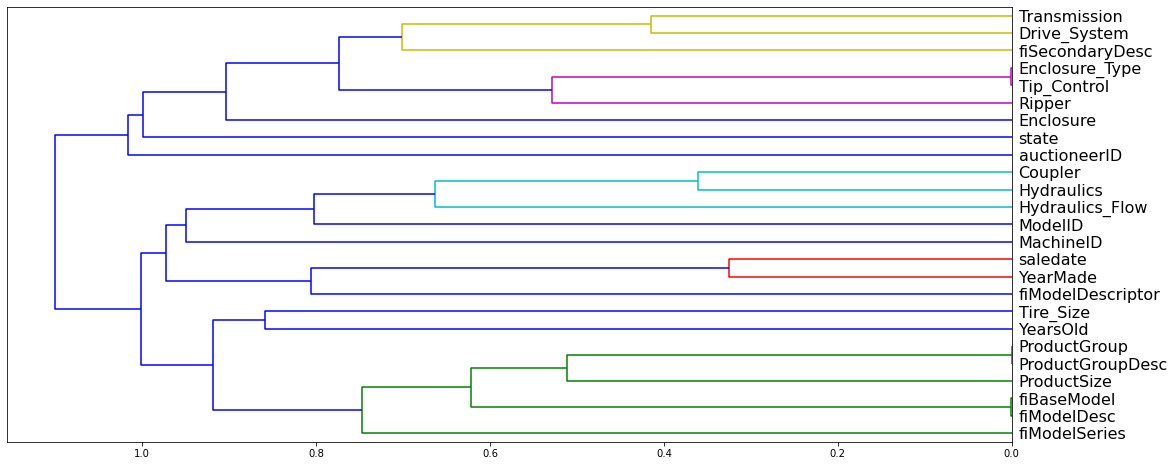

In [44]:
dendogram_spearmanr(X_treino, X_treino.columns)

As colunas Tip_control, ProductGroup e fiModelDesc serão excluídas por serem redundantes.

In [45]:
drop_columns = ['Tip_Control', 'ProductGroup', 'fiModelDesc']

X_treino = X_treino.drop(drop_columns, axis=1)
X_validacao = X_validacao.drop(drop_columns, axis=1)

df_select_important = df_select[list(X_treino.columns) + ['SalePrice']]

### Ajuste do modelo

In [46]:
%%time

m_base = RandomForestRegressor(oob_score = True,
                               random_state=0,
                               n_jobs=-1,
                               max_features =0.5,
                               min_samples_leaf = 2,
                               n_estimators=100
                              )
m_base.fit(X_treino, y_treino)
display_score(m_base)

,RMSE,R2
Treino,0.119478,0.970166
Validação,0.230504,0.905114
OOB,0.213212,0.904992


CPU times: user 4min 23s, sys: 807 ms, total: 4min 24s
Wall time: 1min 13s
